# Build labels of facies
Let's try to label the XRF data and play some data analysis

In [1]:
import os
import pandas as pd
import numpy as np 

#path = '~/GeopolarLabor/#Projekte/WASA'
#os.chdir(path)

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 600
%matplotlib inline

## Import the labels

It's really a hard work to digitalize the labels manualy. The depth is based on the section depth (mm) and includes the part having complete sediments. The holes, cracks and oxidixed parts are excluded mostly. After went through all the description and labels, I realized there are so many uncertainty and inconsistncy during facies discrimination, so I prefer to do some data analysis to strengthen the facies robustness. Detailed notes are in the Goodnotes "WASA translation".

In [3]:
labels_df = pd.read_excel('Facies_translation/facies_labels.xlsx', sheet_name = 'labels')
labels_df.head()

,core_section,upper_limit,lower_limit,facies
0,N10-5,2,128,1
1,N10-4,2,1102,1
2,N10-3,5,1100,1
3,N10-2,2,584,1
4,N10-2,584,1100,3


In [5]:
legends_df = pd.read_excel('Facies_translation/facies_labels.xlsx', sheet_name = 'legends', skiprows = 1)
legends_df

,label,facies,environment,stage,epoch
0,0,lower shoreface,subtidal,not differentiated,holocene
1,1,upper shoreface,subtidal,not differentiated,holocene
2,2,channel lag,subtidal,not differentiated,holocene
3,3,channel fill,subtidal,not differentiated,holocene
4,4,beach-foreshore,intertidal unprotected,not differentiated,holocene
5,5,sand flat,intertidal protected,not differentiated,holocene
6,6,mixed flat,intertidal protected,not differentiated,holocene
7,7,mud flat,intertidal protected,not differentiated,holocene
8,8,lagoon,lagoon,not differentiated,holocene
9,9,marsh,marsh,not differentiated,holocene


In [46]:
labels_df.to_csv('database/facies_labels.csv')
legends_df.to_csv('database/facies_legends.csv')

## Asign the lebels to the XRF data
I only asign to the clr-transformed data since I will use it for subsequent analyses.

In [5]:
labels_df = pd.read_csv('data/facies_labels.csv', index_col = 0)
legends_df = pd.read_csv('data/facies_legends.csv', index_col = 0)

In [6]:
xrf_df = pd.read_csv('data/WASA_XRF_suchen_clr.csv', index_col = 0)
xrf_df.head()

,Ba,Br,Ca,Cl,Fe,K,Mn,Rb,S,Si,Sr,Ti,Zr,composite_depth_mm,section_depth_mm,core_id,core_section
composite_id,,,,,,,,,,,,,,,,,
N10_00001,-1.373621,-4.161713,2.501898,0.111474,1.286639,1.545812,-0.624384,-2.503485,-3.022279,2.202822,-0.816205,1.090560,0.905617,1,1.0,N10,N10-5
N10_00003,-1.483805,-3.443229,2.264830,0.025479,1.288784,1.410660,-1.112473,-1.667470,-2.444700,2.128744,-1.425156,0.762174,0.857614,3,3.0,N10,N10-5
N10_00005,-1.563653,-4.312525,2.489870,0.074178,1.290976,1.543621,-0.835139,-1.256168,-2.703087,2.155368,-1.068957,0.540481,0.829869,5,5.0,N10,N10-5
N10_00007,-1.614133,-3.841211,2.459074,0.151135,1.299389,1.651851,-0.925900,-1.363909,-4.293196,2.318845,-0.906387,0.871590,0.850137,7,7.0,N10,N10-5
N10_00009,-1.366050,-6.210237,3.040189,0.183354,1.437072,1.709483,-0.480137,-1.625269,-3.645287,2.315916,-0.789702,1.261695,0.664995,9,9.0,N10,N10-5


In [7]:
xrf_df.shape

(170436, 17)

### check if the section depth problem previously found fixed

In [8]:
xrf_df.section_depth_mm[xrf_df.core_section == 'N59-1'].head()

composite_id
N59_03306     6.0
N59_03308     8.0
N59_03310    10.0
N59_03312    12.0
N59_03314    14.0
Name: section_depth_mm, dtype: float64

In [9]:
xrf_df.index[xrf_df.index.duplicated()]

Index([], dtype='object', name='composite_id')

In [10]:
facies = []
xrf_fa_df = pd.DataFrame()

for row in labels_df.itertuples():
    X = xrf_df[
        (xrf_df.core_section == row.core_section) & 
        (xrf_df.section_depth_mm >= row.upper_limit) & 
        (xrf_df.section_depth_mm < row.lower_limit)
    ].copy()
    
    facies += [row.facies for _ in range(len(X))]
    xrf_fa_df = xrf_fa_df.append(X)

xrf_fa_df['facies'] = facies

In [11]:
xrf_fa_df.shape

(158909, 18)

In [12]:
xrf_fa_df.index[xrf_fa_df.index.duplicated()]

Index([], dtype='object', name='composite_id')

In [13]:
set(xrf_df.core_section) - set(xrf_fa_df.core_section)

{'N16-3_1',
 'N16-3_2',
 'N16-5',
 'N17-3(1)',
 'N17-3(2)',
 'N17-4(1)',
 'N17-4(2)',
 'N21-2_1',
 'N21-2_2',
 'N22-3(1)',
 'N22-3(2)',
 'N23-5',
 'N25-5',
 'N27-5',
 'N30-5',
 'N31-5',
 'N44-1_1',
 'N44-1_2',
 'N44-1_4',
 'N52-1_1',
 'N52-1_2',
 'N54B-5',
 'N67-1',
 'N67-2',
 'N67-3',
 'N67-4',
 'N73-5',
 'VVC08-1',
 'VVC08-2',
 'VVC08-3',
 'VVC08-4',
 'VVC18-2(A)',
 'VVC18-2(B)',
 'VVC19-5',
 'W6-0',
 'W6-1'}

In [14]:
(xrf_df.shape[0] - xrf_fa_df.shape[0]) / xrf_df.shape[0]

0.06763242507451478

Around 7% of the data points are filtered because they represent the bad quality and edge sediments based on the manul labels. Many of them had xrf measurements but had hole or crack away from the center, so they are excluded to make sure the application for the later on image analysis. Some of the top sections are excluded because they belong to the most abundant facies, channel fill, medium quality and short length. I'm lazy to mark them... Also, the sections with the weird order and naming (e.g., N44-1_1) are filtered out. Details can be found at translation_check.xlsx.

In [16]:
xrf_fa_df['facies'].to_csv('data/XRF_y_label.csv')

## Play data

In [28]:
np.unique(xrf_fa_df['facies'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 18])

In [64]:
des_K  = xrf_fa_df.loc[:, ['K', 'facies']].groupby('facies').mean()
des_K['N'] = xrf_fa_df.iloc[:, -2:].groupby('facies').count()
des_K.reset_index(drop = False, inplace = True)

leg = {}  # build a map
for index in legends_df.index:
    leg[index] = legends_df.facies[index]

des_K['legend'] = des_K.facies.map(leg)
des_K.loc[des_K.legend=='soil-potential settlement surface', 'legend'] = 'soil'
des_K.sort_values('facies', axis = 0, ascending = False, inplace = True)
des_K.reset_index(drop = True, inplace = True)
des_K

,facies,K,N,legend
0,18,1.590237,1871,soil
1,16,1.640867,5544,eolian/fluvial
2,15,2.021909,8464,moraine
3,14,1.881442,20058,shallow marine
4,13,1.829152,8345,eolian/fluvial
5,12,0.372388,604,fen peat
6,11,0.492875,785,bog peat
7,10,0.497418,3494,not differentiated peat
8,8,1.342407,5304,lagoon
9,7,1.670681,1777,mud flat


There is no sediment categorized as 9 (marsh) and 17 (pleistocene peat), which is corresponding to the core description.

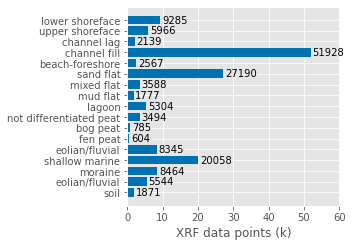

In [65]:
plt.figure(figsize = (5, 3.54))
plt.barh(y = des_K.index, width = des_K.N, tick_label = des_K.legend)
for i in des_K.index:
    plt.text(des_K.N[i] + 500, i, des_K.N[i], va = 'center')
    
locs,_ = plt.xticks()
plt.xticks(locs, [0, 10, 20, 30, 40, 50, 60])
plt.xlabel('XRF data points (k)')
plt.tight_layout()
#plt.savefig('results/xrf_datapoints_fa_{}.png'.format(date))

# Merge peat facies
The bog peat and fen peat are all caled peat now.

In [68]:
def peat_merge(x):
    if x == 11 or x == 12:
        return 10
    else: 
        return x

xrf_fa_df['facies_merge'] = xrf_fa_df.facies.apply(peat_merge)
np.unique(xrf_fa_df.facies_merge)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 13, 14, 15, 16, 18])

In [71]:
xrf_fa_df['facies_merge'].to_csv('data/XRF_y_label.csv')

# Simplify the labels
After discussing with Bernd (20200901), we decide to merge the facies that hard to be differentiated. The ML results based on the old labels are not feasible. The facies are too fragmented. In other words, there are way too many facies changes in one core section. Those scripts using old labels might not be provided in this project since I have new idea about applying ML on these new labels. The upper and lower shoreface deposits are merged into shoreface deposits. The channel fill and lag deposits are merged into channel deposits. We will also try to disolve mixed flat to either sand or mud flats. Hope this can improve the learning result.

In [73]:
#legends_df = pd.read_csv('database/facies_legends.csv', index_col = 0)
facies = [legends_df.at[_, 'facies'] for _ in np.unique(xrf_fa_df.facies_merge)]
facies[-1] = 'soil'
facies[9] = 'peat'

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())
    
Facies[-5] = 'Eolian/fluvial(W)'  # differentiate it from the pre-Weichserian one
Facies

['Lower shoreface',
 'Upper shoreface',
 'Channel lag',
 'Channel fill',
 'Beach-foreshore',
 'Sand flat',
 'Mixed flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Eolian/fluvial(W)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial',
 'Soil']

In [74]:
def plot_facies(y_df, section, y, Facies):
    from skimage import io
    from skimage.transform import rotate
    
    img = rotate(
        io.imread('Kernbeschreibung/{}/{}.jpg'.format(section.split('-')[0], section)), 
        angle = 270, resize = True
          )
    X = y_df[y_df.core_section == section]
    resolution = 0.065 # mm/pixel
    
    fig, ax = plt.subplots(1, 2, sharey = 'row', figsize = (5.7, 7.25))
    ax[0].scatter(X.facies_merge - .1, X.section_depth_mm, marker = 's', s = 1, lw = .5, label = 'Description')
    ax[0].scatter(X[y] + .1, X.section_depth_mm, marker = 's', s = 1, lw = .5, label = 'Prediction', c = 'C2')
    ax[0].set_ylim(X.section_depth_mm.max() + 20, 0)
    ax[0].set_ylabel('Section depth (mm)')
    ax[0].set_xticks(np.unique(y_df[y]))
    ax[0].set_xticklabels(Facies, rotation = 90)
    
    ax[0].legend(bbox_to_anchor = (.78, .055), bbox_transform = plt.gcf().transFigure, 
             markerscale = 4, title = section)
    ax[1].imshow(img[int(25/resolution): int(X.section_depth_mm.max()/resolution)], 
                 extent = (0, 160, X.section_depth_mm.max(), 0)) # arround 25 mm empty
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    fig.subplots_adjust(wspace = .001)
    return fig

## Disolve mixed flat
Detailed figures and judgements are stored in Dissolve mixed flat into sand flat or mud flat.docx. The plots are build using the SVC's result which the scripts arent not shown in this repository. Just to show how fragmented the predictions using the labels without simplication are.

In [75]:
xrf_fa_df

,Ba,Br,Ca,Cl,Fe,K,Mn,Rb,S,Si,Sr,Ti,Zr,composite_depth_mm,section_depth_mm,core_id,core_section,facies,facies_merge
composite_id,,,,,,,,,,,,,,,,,,,
N10_00003,-1.483805,-3.443229,2.264830,0.025479,1.288784,1.410660,-1.112473,-1.667470,-2.444700,2.128744,-1.425156,0.762174,0.857614,3,3.00,N10,N10-5,1,1
N10_00005,-1.563653,-4.312525,2.489870,0.074178,1.290976,1.543621,-0.835139,-1.256168,-2.703087,2.155368,-1.068957,0.540481,0.829869,5,5.00,N10,N10-5,1,1
N10_00007,-1.614133,-3.841211,2.459074,0.151135,1.299389,1.651851,-0.925900,-1.363909,-4.293196,2.318845,-0.906387,0.871590,0.850137,7,7.00,N10,N10-5,1,1
N10_00009,-1.366050,-6.210237,3.040189,0.183354,1.437072,1.709483,-0.480137,-1.625269,-3.645287,2.315916,-0.789702,1.261695,0.664995,9,9.00,N10,N10-5,1,1
N10_00011,-1.460531,-3.029147,3.043206,-0.102407,1.169057,1.470293,-0.835633,-2.048317,-3.211468,2.103116,-0.900915,1.040450,0.765593,11,11.00,N10,N10-5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02163,-1.663530,-0.000025,2.614871,2.403595,0.634880,0.123589,0.914158,-2.178996,0.855509,-3.860755,-0.631929,-2.995757,-2.443689,2163,1123.01,W5,W5-1,11,10
W5_02183,-1.270126,-0.056001,2.585218,2.466328,-0.412676,0.410207,0.999261,-4.245656,0.908791,-2.964722,-0.503236,-2.299746,-2.358586,2183,1143.01,W5,W5-1,11,10
W5_02185,-1.646748,0.147173,2.367878,2.344158,0.089379,0.093946,0.917201,-2.161912,0.684008,-3.592659,-0.606059,-3.217965,-1.673066,2185,1145.01,W5,W5-1,11,10


In [76]:
np.unique(xrf_fa_df.core_section[xrf_fa_df.facies_merge == 6])

array(['N35-1', 'N35-2', 'N38-2', 'N38-3', 'N47-5', 'N51-1', 'N51-2',
       'N52-2', 'N52-3', 'N54-4', 'VVC22-4', 'W4-3', 'W5-2'], dtype=object)

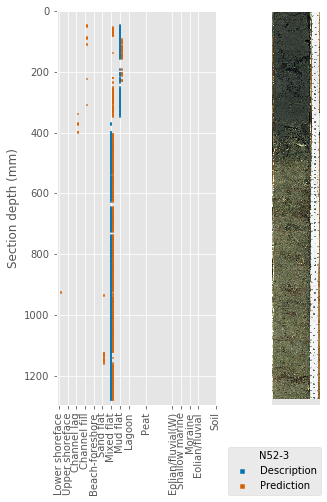

In [14]:
plot_facies(y_df, 'N52-3', 'y_svc', Facies).savefig('analysis_ML/results/N52-3.png')

In [ ]:
for section in np.unique(y_df.core_section[y_df.facies_merge == 6]):
    plot_facies(y_df, section, 'y_svc', Facies).savefig('analysis_ML/results/{}.png'.format(section))

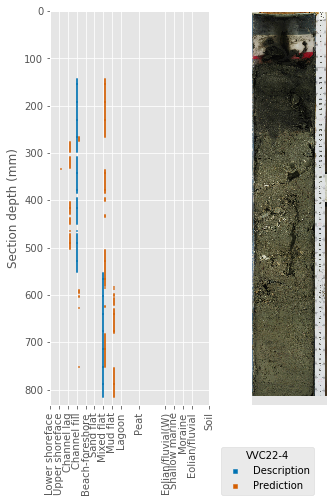

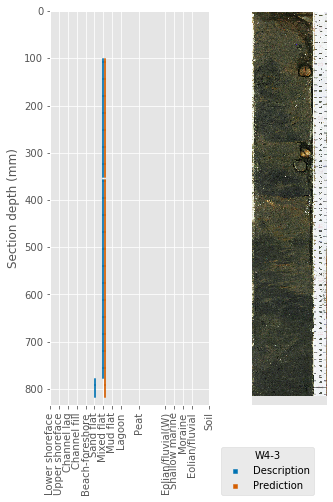

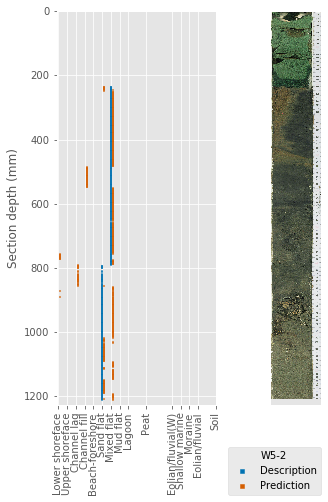

In [16]:
for section in ['VVC22-4', 'W4-3', 'W5-2']:
    plot_facies(y_df, section, 'y_svc', Facies).savefig('analysis_ML/results/{}.png'.format(section))

## Assign new labels
I merge the facies and aslo sort the order chronogically without the non-existed facies.

In [5]:
legends_df

,label,facies,environment,stage,epoch
0,0,lower shoreface,subtidal,not differentiated,holocene
1,1,upper shoreface,subtidal,not differentiated,holocene
2,2,channel lag,subtidal,not differentiated,holocene
3,3,channel fill,subtidal,not differentiated,holocene
4,4,beach-foreshore,intertidal unprotected,not differentiated,holocene
5,5,sand flat,intertidal protected,not differentiated,holocene
6,6,mixed flat,intertidal protected,not differentiated,holocene
7,7,mud flat,intertidal protected,not differentiated,holocene
8,8,lagoon,lagoon,not differentiated,holocene
9,9,marsh,marsh,not differentiated,holocene


In [23]:
legends_df['new_label'] = [0, 0, 1, 1, 2, 3, 98, 4, 5, 99, 6, 6, 6, 8, 9, 10, 11, 100, 7]
legends_df

,label,facies,environment,stage,epoch,new_label
0,0,lower shoreface,subtidal,not differentiated,holocene,0
1,1,upper shoreface,subtidal,not differentiated,holocene,0
2,2,channel lag,subtidal,not differentiated,holocene,1
3,3,channel fill,subtidal,not differentiated,holocene,1
4,4,beach-foreshore,intertidal unprotected,not differentiated,holocene,2
5,5,sand flat,intertidal protected,not differentiated,holocene,3
6,6,mixed flat,intertidal protected,not differentiated,holocene,98
7,7,mud flat,intertidal protected,not differentiated,holocene,4
8,8,lagoon,lagoon,not differentiated,holocene,5
9,9,marsh,marsh,not differentiated,holocene,99


In [24]:
legends_df.to_csv('data/facies_legends.csv')

In [77]:
#legends_df = pd.read_csv('database/facies_legends.csv', index_col = 0)
mapp = pd.Series(legends_df.new_label.values, index = legends_df.label.values).to_dict()
mapp

{0: 0,
 1: 0,
 2: 1,
 3: 1,
 4: 2,
 5: 3,
 6: 98,
 7: 4,
 8: 5,
 9: 99,
 10: 6,
 11: 6,
 12: 6,
 13: 8,
 14: 9,
 15: 10,
 16: 11,
 17: 100,
 18: 7}

In [78]:
xrf_fa_df['facies_merge_1'] = xrf_fa_df.facies_merge.map(mapp)

In [80]:
np.unique(xrf_fa_df['facies_merge_1'] )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 98])

Now the shoreface and channel deposits are merged respectively. We then deal with the mixed flat.

In [82]:
# the mixed sand flat facies in these sections are judged as mud flat.
for section in ['N47-5', 'N54-4', 'VVC22-4']:
    mask = (xrf_fa_df.core_section == section) & (xrf_fa_df.facies_merge_1 == 98)
    xrf_fa_df.loc[mask, 'facies_merge_1'] = 4

np.unique(xrf_fa_df.facies_merge_1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 98])

In [83]:
# rest of the mixed sand flat facies are judged as sand flat
xrf_fa_df.loc[xrf_fa_df.facies_merge_1 == 98, 'facies_merge_1'] = 3

np.unique(xrf_fa_df.facies_merge_1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

The amount of facies reduced from 15 to 12. (one from channel deposits, one from shoreface deposits, one is the mixed flat.)

In [84]:
print('The original amount of mixed flat: {}'.format(len(xrf_fa_df[xrf_fa_df.facies_merge == 6])))
print('The original amount of sand flat: {}'.format(len(xrf_fa_df[xrf_fa_df.facies_merge == 5])))
print('The new amount of sand flat: {}'.format(len(xrf_fa_df[xrf_fa_df.facies_merge_1 == 3])))
print('The original amount of mud flat {}'.format(len(xrf_fa_df[xrf_fa_df.facies_merge == 7])))
print('The new amount of mud flat: {}'.format(len(xrf_fa_df[xrf_fa_df.facies_merge_1 == 4])))

The original amount of mixed flat: 3588
The original amount of sand flat: 27190
The new amount of sand flat: 30323
The original amount of mud flat 1777
The new amount of mud flat: 2232


In [85]:
(len(xrf_fa_df[xrf_fa_df.facies_merge_1 == 4]) - len(xrf_fa_df[xrf_fa_df.facies_merge == 7])) + (len(xrf_fa_df[xrf_fa_df.facies_merge_1 == 3]) - len(xrf_fa_df[xrf_fa_df.facies_merge == 5]))

3588

The increase amount in sand and mud flat is equal to the original mixed flat.

## Export the new label

In [86]:
xrf_fa_df['facies_merge_1'].to_csv('data/XRF_y_label.csv')

From now on, the Facies need to be produced by these codes.

In [7]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

# Update labels
Change the mud flat labels in core section N47-5 to sand flat based on the investigation in ML_element_04.ipynb.

In [3]:
y_df = pd.read_csv('data/XRF_y_label.csv', index_col=0)
y_df

,facies_merge_1
composite_id,
N10_00003,0
N10_00005,0
N10_00007,0
N10_00009,0
N10_00011,0
...,...
W5_02163,6
W5_02183,6
W5_02185,6


In [5]:
xrf_fa_df = pd.read_csv('data/XRF_ML.csv', index_col=0)
xrf_fa_df

,composite_depth_mm,core_id,core_section,section_depth_mm,facies_merge_1,Ba,Br,Ca,Cl,Fe,K,Rb,S,Si,Sr,Ti,Zr
composite_id,,,,,,,,,,,,,,,,,
N10_00003,3,N10,N10-5,3.0,0,149,0,6327,674,2384,2693,124,57,5522,158,1408,1549
N10_00005,5,N10,N10-5,5.0,0,125,8,7200,643,2171,2795,170,40,5153,205,1025,1369
N10_00007,7,N10,N10-5,7.0,0,102,11,5992,596,1879,2673,131,7,5208,207,1225,1199
N10_00009,9,N10,N10-5,9.0,0,127,0,10409,598,2095,2751,98,13,5045,226,1758,968
N10_00011,11,N10,N10-5,11.0,0,144,30,13011,560,1997,2699,80,25,5082,252,1756,1334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02163,2163,W5,W5-1,2163.0,6,72,380,5193,4204,717,430,43,894,8,202,0,33
W5_02183,2183,W5,W5-1,2183.0,6,98,330,4630,4111,231,526,0,866,18,211,0,33
W5_02185,2185,W5,W5-1,2185.0,6,77,463,4266,4166,437,439,0,792,11,218,16,75


In [6]:
xrf_fa_df.loc[(xrf_fa_df.facies_merge_1==4) & (xrf_fa_df.core_section=='N47-5'), 'facies_merge_1']

composite_id
N47_00011    4
N47_00013    4
N47_00015    4
N47_00017    4
N47_00019    4
            ..
N47_00401    4
N47_00403    4
N47_00405    4
N47_00407    4
N47_00409    4
Name: facies_merge_1, Length: 182, dtype: int64

The length 182 is equivalent to the length after rolling (166) plus 16 lost data points.

In [7]:
xrf_fa_df.loc[(xrf_fa_df.facies_merge_1==4) & (xrf_fa_df.core_section=='N47-5'), 'facies_merge_1'] = 3
np.unique(xrf_fa_df.loc[xrf_fa_df.core_section=='N47-5', 'facies_merge_1'])

array([3])

In [15]:
cols = ['facies_merge_2' if col=='facies_merge_1' else col for col in xrf_fa_df.columns]
cols

['composite_depth_mm',
 'core_id',
 'core_section',
 'section_depth_mm',
 'facies_merge_2',
 'Ba',
 'Br',
 'Ca',
 'Cl',
 'Fe',
 'K',
 'Rb',
 'S',
 'Si',
 'Sr',
 'Ti',
 'Zr']

In [16]:
xrf_fa_df.columns = cols

## Export and update datasets

### XRF_y_label.csv

In [17]:
xrf_fa_df['facies_merge_2'].to_csv('data/XRF_y_label.csv')

### XRF_ML.csv

In [18]:
xrf_fa_df.to_csv('data/XRF_ML.csv')

### XRF_spe_ML.csv

In [10]:
ml_spe_df = pd.read_csv('data/XRF_spe_ML.csv', index_col=0)
ml_spe_df.shape

(158909, 1029)

In [24]:
ml_spe_df = pd.concat([xrf_fa_df.facies_merge_2, ml_spe_df.loc[:, ml_spe_df.columns!='facies_merge_1']], 
                      join='inner', axis=1)
ml_spe_df.shape

(158909, 1029)

In [26]:
# check
np.unique(ml_spe_df.loc[ml_spe_df.core_section=='N47-5', 'facies_merge_2'])

array([3])

In [32]:
new_cols = np.hstack((['composite_depth_mm', 'core_id', 'core_section', 'section_depth_mm', 'facies_merge_2'], 
                      ml_spe_df.columns[5:]))
new_cols

array(['composite_depth_mm', 'core_id', 'core_section', ..., '1022',
       '1023', '1024'], dtype=object)

In [35]:
# make the column's order consistent
ml_spe_df[new_cols].to_csv('data/XRF_spe_ML.csv')
ml_spe_df[new_cols]

,composite_depth_mm,core_id,core_section,section_depth_mm,facies_merge_2,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_00003,3,N10,N10-5,3.0,0,0,0,0,0,0,...,86,87,92,77,87,102,97,83,85,10
N10_00005,5,N10,N10-5,5.0,0,0,0,0,0,0,...,95,77,84,68,96,80,72,73,92,23
N10_00007,7,N10,N10-5,7.0,0,0,0,0,0,0,...,84,81,98,84,82,81,99,80,100,26
N10_00009,9,N10,N10-5,9.0,0,0,0,0,0,0,...,76,79,80,76,95,81,82,76,85,12
N10_00011,11,N10,N10-5,11.0,0,0,0,0,0,0,...,83,88,83,76,74,92,80,87,88,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_02163,2163,W5,W5-1,2163.0,6,0,0,0,0,0,...,101,99,100,85,103,98,109,84,93,10
W5_02183,2183,W5,W5-1,2183.0,6,0,0,0,0,0,...,105,93,104,94,94,76,96,109,97,0
W5_02185,2185,W5,W5-1,2185.0,6,0,0,0,0,0,...,107,114,90,86,90,99,88,102,82,21


### XRF_ML_cr.csv

In [41]:
ml_cr_df = pd.read_csv('data/XRF_ML_cr.csv', index_col=0)
ml_cr_df

,Ba_mean,Br_mean,Ca_mean,Cl_mean,Fe_mean,K_mean,Rb_mean,S_mean,Si_mean,Sr_mean,...,Fe_std,K_std,Rb_std,S_std,Si_std,Sr_std,Ti_std,Zr_std,facies_merge_1,core_section
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_03460,-2.149582,-2.301706,3.358506,0.730416,2.535087,1.698956,-1.611358,-1.703103,0.070642,-0.968070,...,0.059833,0.046311,0.138985,0.136754,0.091019,0.060907,0.053279,0.144020,1,N10-1
N10_03462,-2.132442,-2.318665,3.353933,0.717854,2.526969,1.695766,-1.613764,-1.686102,0.071552,-0.973912,...,0.055213,0.044010,0.138831,0.105753,0.091359,0.054621,0.053122,0.131878,1,N10-1
N10_03464,-2.140558,-2.326715,3.354920,0.710969,2.522705,1.694375,-1.615556,-1.678517,0.082337,-0.972268,...,0.055973,0.043194,0.138803,0.100158,0.099555,0.055032,0.052643,0.142605,1,N10-1
N10_03466,-2.132979,-2.343380,3.355639,0.699013,2.512536,1.694095,-1.627726,-1.675207,0.092482,-0.969648,...,0.065025,0.043231,0.143668,0.096235,0.098671,0.054823,0.052619,0.170292,1,N10-1
N10_03468,-2.132173,-2.369807,3.354430,0.687102,2.499641,1.693513,-1.622623,-1.676050,0.111802,-0.976699,...,0.080550,0.043524,0.137869,0.096651,0.102500,0.061061,0.053835,0.226116,1,N10-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_00990,-1.783972,-3.424821,3.011888,0.537308,1.639323,1.642630,-1.644164,-1.232472,1.541068,-1.013751,...,0.144343,0.227519,0.346170,0.184069,0.276648,0.215515,0.239393,0.207739,3,W5-2
W5_00992,-1.773856,-3.605693,3.020657,0.546424,1.647041,1.663988,-1.635890,-1.234159,1.565420,-0.998921,...,0.145924,0.246197,0.354460,0.184762,0.310457,0.216876,0.262774,0.250893,3,W5-2
W5_00994,-1.758358,-3.679957,3.010741,0.542528,1.637066,1.666015,-1.640720,-1.234901,1.578417,-1.002264,...,0.156198,0.247383,0.351778,0.186129,0.319131,0.219212,0.266318,0.292603,3,W5-2


In [42]:
ml_cr_df = pd.concat([ml_cr_df.loc[:, ml_cr_df.columns!='facies_merge_1'], xrf_fa_df.facies_merge_2], 
                      join='inner', axis=1)
ml_cr_df

,Ba_mean,Br_mean,Ca_mean,Cl_mean,Fe_mean,K_mean,Rb_mean,S_mean,Si_mean,Sr_mean,...,Fe_std,K_std,Rb_std,S_std,Si_std,Sr_std,Ti_std,Zr_std,core_section,facies_merge_2
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_03460,-2.149582,-2.301706,3.358506,0.730416,2.535087,1.698956,-1.611358,-1.703103,0.070642,-0.968070,...,0.059833,0.046311,0.138985,0.136754,0.091019,0.060907,0.053279,0.144020,N10-1,1
N10_03462,-2.132442,-2.318665,3.353933,0.717854,2.526969,1.695766,-1.613764,-1.686102,0.071552,-0.973912,...,0.055213,0.044010,0.138831,0.105753,0.091359,0.054621,0.053122,0.131878,N10-1,1
N10_03464,-2.140558,-2.326715,3.354920,0.710969,2.522705,1.694375,-1.615556,-1.678517,0.082337,-0.972268,...,0.055973,0.043194,0.138803,0.100158,0.099555,0.055032,0.052643,0.142605,N10-1,1
N10_03466,-2.132979,-2.343380,3.355639,0.699013,2.512536,1.694095,-1.627726,-1.675207,0.092482,-0.969648,...,0.065025,0.043231,0.143668,0.096235,0.098671,0.054823,0.052619,0.170292,N10-1,1
N10_03468,-2.132173,-2.369807,3.354430,0.687102,2.499641,1.693513,-1.622623,-1.676050,0.111802,-0.976699,...,0.080550,0.043524,0.137869,0.096651,0.102500,0.061061,0.053835,0.226116,N10-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_00990,-1.783972,-3.424821,3.011888,0.537308,1.639323,1.642630,-1.644164,-1.232472,1.541068,-1.013751,...,0.144343,0.227519,0.346170,0.184069,0.276648,0.215515,0.239393,0.207739,W5-2,3
W5_00992,-1.773856,-3.605693,3.020657,0.546424,1.647041,1.663988,-1.635890,-1.234159,1.565420,-0.998921,...,0.145924,0.246197,0.354460,0.184762,0.310457,0.216876,0.262774,0.250893,W5-2,3
W5_00994,-1.758358,-3.679957,3.010741,0.542528,1.637066,1.666015,-1.640720,-1.234901,1.578417,-1.002264,...,0.156198,0.247383,0.351778,0.186129,0.319131,0.219212,0.266318,0.292603,W5-2,3


In [43]:
# check
np.unique(ml_cr_df.loc[ml_cr_df.core_section=='N47-5', 'facies_merge_2'])

array([3])

In [44]:
new_cols = np.hstack((ml_cr_df.columns[:-2], ['facies_merge_2', 'core_section']))
new_cols

array(['Ba_mean', 'Br_mean', 'Ca_mean', 'Cl_mean', 'Fe_mean', 'K_mean',
       'Rb_mean', 'S_mean', 'Si_mean', 'Sr_mean', 'Ti_mean', 'Zr_mean',
       'Ba_std', 'Br_std', 'Ca_std', 'Cl_std', 'Fe_std', 'K_std',
       'Rb_std', 'S_std', 'Si_std', 'Sr_std', 'Ti_std', 'Zr_std',
       'facies_merge_2', 'core_section'], dtype=object)

In [45]:
# make the column's order consistent
ml_cr_df[new_cols].to_csv('data/XRF_ML_cr.csv')
ml_cr_df[new_cols]

,Ba_mean,Br_mean,Ca_mean,Cl_mean,Fe_mean,K_mean,Rb_mean,S_mean,Si_mean,Sr_mean,...,Fe_std,K_std,Rb_std,S_std,Si_std,Sr_std,Ti_std,Zr_std,facies_merge_2,core_section
composite_id,,,,,,,,,,,,,,,,,,,,,
N10_03460,-2.149582,-2.301706,3.358506,0.730416,2.535087,1.698956,-1.611358,-1.703103,0.070642,-0.968070,...,0.059833,0.046311,0.138985,0.136754,0.091019,0.060907,0.053279,0.144020,1,N10-1
N10_03462,-2.132442,-2.318665,3.353933,0.717854,2.526969,1.695766,-1.613764,-1.686102,0.071552,-0.973912,...,0.055213,0.044010,0.138831,0.105753,0.091359,0.054621,0.053122,0.131878,1,N10-1
N10_03464,-2.140558,-2.326715,3.354920,0.710969,2.522705,1.694375,-1.615556,-1.678517,0.082337,-0.972268,...,0.055973,0.043194,0.138803,0.100158,0.099555,0.055032,0.052643,0.142605,1,N10-1
N10_03466,-2.132979,-2.343380,3.355639,0.699013,2.512536,1.694095,-1.627726,-1.675207,0.092482,-0.969648,...,0.065025,0.043231,0.143668,0.096235,0.098671,0.054823,0.052619,0.170292,1,N10-1
N10_03468,-2.132173,-2.369807,3.354430,0.687102,2.499641,1.693513,-1.622623,-1.676050,0.111802,-0.976699,...,0.080550,0.043524,0.137869,0.096651,0.102500,0.061061,0.053835,0.226116,1,N10-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W5_00990,-1.783972,-3.424821,3.011888,0.537308,1.639323,1.642630,-1.644164,-1.232472,1.541068,-1.013751,...,0.144343,0.227519,0.346170,0.184069,0.276648,0.215515,0.239393,0.207739,3,W5-2
W5_00992,-1.773856,-3.605693,3.020657,0.546424,1.647041,1.663988,-1.635890,-1.234159,1.565420,-0.998921,...,0.145924,0.246197,0.354460,0.184762,0.310457,0.216876,0.262774,0.250893,3,W5-2
W5_00994,-1.758358,-3.679957,3.010741,0.542528,1.637066,1.666015,-1.640720,-1.234901,1.578417,-1.002264,...,0.156198,0.247383,0.351778,0.186129,0.319131,0.219212,0.266318,0.292603,3,W5-2


### Visualize the distribution

In [3]:
label = pd.read_csv('data/XRF_y_label.csv', index_col=0, squeeze=True)

In [4]:
np.unique(label, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([15251, 54067,  2567, 30505,  2050,  5304,  4883,  1871,  8345,
        20058,  8464,  5544]))

In [8]:
counts = pd.DataFrame({'Facies': Facies, 'N': np.unique(label, return_counts=True)[1]})
counts

,Facies,N
0,Shoreface,15251
1,Channel,54067
2,Beach-foreshore,2567
3,Sand flat,30505
4,Mud flat,2050
5,Lagoon,5304
6,Peat,4883
7,Soil,1871
8,Eolian/fluvial (w),8345
9,Shallow marine,20058


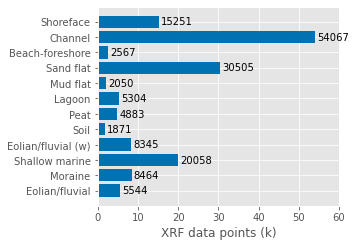

In [14]:
plt.figure(figsize = (5, 3.54))
plt.barh(y = counts.Facies[::-1], width = counts.N[::-1])
for i in counts.index:
    plt.text(counts.N[i] + 500,  counts.Facies[i], counts.N[i], va = 'center')
    
locs,_ = plt.xticks()
plt.xticks(locs, [0, 10, 20, 30, 40, 50, 60])
plt.xlabel('XRF data points (k)')
plt.tight_layout()
plt.savefig('results/xrf_datapoints_fa_{}.png'.format(date))